In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import json
import pickle
import keras
import cv2
import mediapipe

objc[15254]: Class CaptureDelegate is implemented in both /opt/homebrew/Cellar/opencv/4.6.0/lib/libopencv_videoio.4.6.0.dylib (0x161c08860) and /opt/homebrew/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x16a3b8860). One of the two will be used. Which one is undefined.
objc[15254]: Class CVWindow is implemented in both /opt/homebrew/Cellar/opencv/4.6.0/lib/libopencv_highgui.4.6.0.dylib (0x160a34af0) and /opt/homebrew/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1698d8a68). One of the two will be used. Which one is undefined.
objc[15254]: Class CVView is implemented in both /opt/homebrew/Cellar/opencv/4.6.0/lib/libopencv_highgui.4.6.0.dylib (0x160a34b18) and /opt/homebrew/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1698d8a90). One of the two will be used. Which one is undefined.
objc[15254]: Class CVSlider is implemented in both /opt/homebrew/Cellar/opencv/4.6.0/lib/libopencv_highg

In [2]:
with open('landmarks.npy', 'rb') as f:
    landmark_lst = np.load(f, allow_pickle=True)
with open('labels.npy', 'rb') as f:
    label_arr = np.load(f, allow_pickle=True)

In [3]:
label_lst = list(label_arr)

In [4]:
# create a list of landmarks in each frame in each video
videos = []
for video in landmark_lst:
    frames = []
    for frame in video:
        if frame != None:
            datapoints = []
            for datapoint in frame[0].landmark:
                datapoints.append(datapoint.x)
                datapoints.append(datapoint.y)
                datapoints.append(datapoint.z)
            frames.append(datapoints)
    videos.append(frames)

In [5]:
print('number of videos:', len(videos))
print('number of labels:', len(label_arr))

number of videos: 2200
number of labels: 2200


In [6]:
# five randomly selected words for the first three models
# selected_labels = ['thanks','dance','deaf','name','where']
# selected_idxs = []

# for index, label in enumerate (label_lst):
#     if label not in selected_labels:
#         selected_idxs.append(index)

# for index in sorted(selected_idxs, reverse=True):
#     del videos[index]
#     del label_lst[index]

In [7]:
# select the video with under 20 frames
video_with_frame_under_20_idx = []
for index, video in enumerate (videos):
    if len(video) <= 20:
        video_with_frame_under_20_idx.append(index)

In [8]:
print('number of videos with under 20 frames: ', len(video_with_frame_under_20_idx))

number of videos with under 20 frames:  835


In [9]:
# delete the videos with under 20 frames
for index in sorted(video_with_frame_under_20_idx, reverse=True):
    del videos[index]
    del label_lst[index]

In [10]:
print('number of videos:', len(videos))
print('number of labels:', len(label_lst))
print('number of label types:', len(set(label_lst)))

number of videos: 1365
number of labels: 1365
number of label types: 44


In [11]:
# count the videos left for each classes
from collections import Counter
videos_left = []
counts = Counter(label_lst)
counts

Counter({'pink': 32,
         'thanks': 41,
         'catch': 48,
         'deaf': 35,
         'music': 46,
         'birthday': 28,
         'milk': 45,
         'copy': 24,
         'learn': 50,
         'appear': 11,
         'yellow': 50,
         'find': 39,
         'realize': 10,
         'country': 48,
         'bitter': 50,
         'bright': 50,
         'candy': 37,
         'run': 15,
         'gum': 47,
         'red': 42,
         'mock': 8,
         'call': 37,
         'give': 38,
         'land': 46,
         'food': 14,
         'water': 34,
         'accept': 20,
         'sweet': 27,
         'away': 35,
         'help': 30,
         'breakfast': 38,
         'perfume': 38,
         'Women / woman': 23,
         'name': 39,
         'dance': 8,
         'colors/ color': 25,
         'buy': 27,
         'drawer': 9,
         'hungry': 13,
         'son': 27,
         'green': 26,
         'where': 28,
         'none': 25,
         'man': 2})

In [12]:
# select the words with more than 20 videos
selected_labels = []
for label in set(label_lst):
    if counts[label] >= 20:
        selected_labels.append(label)

In [13]:
print(len(selected_labels))
print(selected_labels)

35
['accept', 'away', 'catch', 'colors/ color', 'call', 'music', 'sweet', 'copy', 'buy', 'red', 'land', 'where', 'give', 'pink', 'candy', 'bitter', 'green', 'perfume', 'find', 'help', 'gum', 'bright', 'water', 'Women / woman', 'birthday', 'milk', 'none', 'learn', 'thanks', 'breakfast', 'country', 'name', 'yellow', 'son', 'deaf']


In [14]:
# delete the words with less than 20 videos
selected_idxs = []

for index, label in enumerate (label_lst):
    if label not in selected_labels:
        selected_idxs.append(index)

for index in sorted(selected_idxs, reverse=True):
    del videos[index]
    del label_lst[index]

In [15]:
print(len(videos))
print(len(label_lst))

1275
1275


## Preprocessing

In [16]:
num_videos = len(videos)
num_frames = 58
num_feature = 126 #3*42

In [17]:
# convert string labels to numeric labels
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(label_lst))
print(label_processor.get_vocabulary())

labels = label_processor(label_lst).numpy()

['Women / woman', 'accept', 'away', 'birthday', 'bitter', 'breakfast', 'bright', 'buy', 'call', 'candy', 'catch', 'colors/ color', 'copy', 'country', 'deaf', 'find', 'give', 'green', 'gum', 'help', 'land', 'learn', 'milk', 'music', 'name', 'none', 'perfume', 'pink', 'red', 'son', 'sweet', 'thanks', 'water', 'where', 'yellow']


/opt/homebrew/lib/python3.10/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [18]:
# stratified train test split at 75%
X_train, X_test, y_train, y_test = train_test_split(videos, labels, stratify=labels, train_size=0.75, random_state=42)

In [19]:
# train
frame_masks_train = np.zeros(shape=(len(X_train), num_frames), dtype="bool") 
frame_features_train = np.zeros(shape=(len(X_train), num_frames, num_feature), dtype="float32")

for idx, video in enumerate(X_train):
    for i, frame in enumerate(video):  
        frame_features_train[idx, i, 0:len(frame)] = frame
        frame_masks_train[idx, i] = 1  # 1 = not masked, 0 = masked

In [20]:
# mask the frames and features
frame_masks_test = np.zeros(shape=(len(X_test), num_frames), dtype="bool")
frame_features_test = np.zeros(shape=(len(X_test), num_frames, num_feature), dtype="float32")

for idx, video in enumerate(X_test):
    for i, frame in enumerate(video):  
        frame_features_test[idx, i, 0:len(frame)] = frame
        frame_masks_test[idx, i] = 1  # 1 = not masked, 0 = masked

In [21]:
train = (frame_features_train, frame_masks_train)
test = (frame_features_test, frame_masks_test)

In [22]:
len(frame_features_test[0])

58

## Train Model

In [23]:
# build RNN model 
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((num_frames, num_feature))
    mask_input = keras.Input((num_frames,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [24]:
# Run experiment
EPOCHS = 500
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train[0], train[1]],
        y_train,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test[0], test[1]], y_test)
    print(accuracy)

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/500


2022-12-11 12:00:40.552080: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19/21 [==========================>...] - ETA: 0s - loss: 3.5569 - accuracy: 0.0395
Epoch 1: val_loss improved from inf to 3.55411, saving model to ./tmp/video_classifier
21/21 [==============================] - 4s 73ms/step - loss: 3.5568 - accuracy: 0.0389 - val_loss: 3.5541 - val_accuracy: 0.0488
Epoch 2/500
21/21 [==============================] - ETA: 0s - loss: 3.5534 - accuracy: 0.0359
Epoch 2: val_loss improved from 3.55411 to 3.54960, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 19ms/step - loss: 3.5534 - accuracy: 0.0359 - val_loss: 3.5496 - val_accuracy: 0.0697
Epoch 3/500
21/21 [==============================] - ETA: 0s - loss: 3.5418 - accuracy: 0.0643
Epoch 3: val_loss improved from 3.54960 to 3.53681, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 19ms/step - loss: 3.5418 - accuracy: 0.0643 - val_loss: 3.5368 - val_accuracy: 0.0523
Epoch 4/500
20/21 [===========================>..] - ETA: 0s - loss:

19/21 [==========================>...] - ETA: 0s - loss: 2.9116 - accuracy: 0.1447
Epoch 27: val_loss improved from 3.03166 to 3.01633, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 2.9319 - accuracy: 0.1375 - val_loss: 3.0163 - val_accuracy: 0.0941
Epoch 28/500
19/21 [==========================>...] - ETA: 0s - loss: 2.9323 - accuracy: 0.1266
Epoch 28: val_loss improved from 3.01633 to 3.01357, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 2.9182 - accuracy: 0.1286 - val_loss: 3.0136 - val_accuracy: 0.1045
Epoch 29/500
19/21 [==========================>...] - ETA: 0s - loss: 2.9245 - accuracy: 0.1497
Epoch 29: val_loss improved from 3.01357 to 2.98615, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 2.9189 - accuracy: 0.1495 - val_loss: 2.9861 - val_accuracy: 0.1010
Epoch 30/500
19/21 [==========================>...] - ETA: 

21/21 [==============================] - 0s 20ms/step - loss: 2.5956 - accuracy: 0.1958 - val_loss: 2.6971 - val_accuracy: 0.1847
Epoch 54/500
19/21 [==========================>...] - ETA: 0s - loss: 2.5972 - accuracy: 0.1875
Epoch 54: val_loss improved from 2.69710 to 2.67346, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 2.6094 - accuracy: 0.1868 - val_loss: 2.6735 - val_accuracy: 0.1812
Epoch 55/500
19/21 [==========================>...] - ETA: 0s - loss: 2.6157 - accuracy: 0.1908
Epoch 55: val_loss did not improve from 2.67346
21/21 [==============================] - 0s 19ms/step - loss: 2.6013 - accuracy: 0.1913 - val_loss: 2.6840 - val_accuracy: 0.1812
Epoch 56/500
19/21 [==========================>...] - ETA: 0s - loss: 2.5576 - accuracy: 0.1924
Epoch 56: val_loss improved from 2.67346 to 2.65222, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 21ms/step - loss: 2.5589 - accuracy: 0.2048 - 

Epoch 81/500
19/21 [==========================>...] - ETA: 0s - loss: 2.3811 - accuracy: 0.2122
Epoch 81: val_loss improved from 2.46242 to 2.45302, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 2.3722 - accuracy: 0.2108 - val_loss: 2.4530 - val_accuracy: 0.2404
Epoch 82/500
19/21 [==========================>...] - ETA: 0s - loss: 2.4188 - accuracy: 0.2319
Epoch 82: val_loss improved from 2.45302 to 2.43707, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 21ms/step - loss: 2.4198 - accuracy: 0.2302 - val_loss: 2.4371 - val_accuracy: 0.2125
Epoch 83/500
19/21 [==========================>...] - ETA: 0s - loss: 2.4106 - accuracy: 0.2138
Epoch 83: val_loss did not improve from 2.43707
21/21 [==============================] - 0s 20ms/step - loss: 2.4138 - accuracy: 0.2138 - val_loss: 2.4826 - val_accuracy: 0.2544
Epoch 84/500
19/21 [==========================>...] - ETA: 0s - loss: 2.3710 - accuracy: 0

Epoch 109/500
19/21 [==========================>...] - ETA: 0s - loss: 2.2668 - accuracy: 0.2500
Epoch 109: val_loss did not improve from 2.32922
21/21 [==============================] - 0s 19ms/step - loss: 2.2506 - accuracy: 0.2541 - val_loss: 2.3390 - val_accuracy: 0.3136
Epoch 110/500
19/21 [==========================>...] - ETA: 0s - loss: 2.2642 - accuracy: 0.2615
Epoch 110: val_loss did not improve from 2.32922
21/21 [==============================] - 0s 19ms/step - loss: 2.2582 - accuracy: 0.2571 - val_loss: 2.3344 - val_accuracy: 0.3206
Epoch 111/500
19/21 [==========================>...] - ETA: 0s - loss: 2.2700 - accuracy: 0.2484
Epoch 111: val_loss did not improve from 2.32922
21/21 [==============================] - 0s 19ms/step - loss: 2.2587 - accuracy: 0.2556 - val_loss: 2.3970 - val_accuracy: 0.3066
Epoch 112/500
19/21 [==========================>...] - ETA: 0s - loss: 2.2377 - accuracy: 0.2533
Epoch 112: val_loss did not improve from 2.32922
21/21 [===================

19/21 [==========================>...] - ETA: 0s - loss: 2.1754 - accuracy: 0.2681
Epoch 137: val_loss improved from 2.25163 to 2.23459, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 21ms/step - loss: 2.1787 - accuracy: 0.2676 - val_loss: 2.2346 - val_accuracy: 0.3275
Epoch 138/500
19/21 [==========================>...] - ETA: 0s - loss: 2.1219 - accuracy: 0.2812
Epoch 138: val_loss improved from 2.23459 to 2.23394, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 21ms/step - loss: 2.1190 - accuracy: 0.2810 - val_loss: 2.2339 - val_accuracy: 0.3031
Epoch 139/500
19/21 [==========================>...] - ETA: 0s - loss: 2.1200 - accuracy: 0.2615
Epoch 139: val_loss did not improve from 2.23394
21/21 [==============================] - 0s 19ms/step - loss: 2.1095 - accuracy: 0.2720 - val_loss: 2.2669 - val_accuracy: 0.3240
Epoch 140/500
19/21 [==========================>...] - ETA: 0s - loss: 2.1752 - accuracy: 0.2862
E

19/21 [==========================>...] - ETA: 0s - loss: 2.0670 - accuracy: 0.2878
Epoch 165: val_loss improved from 2.15617 to 2.13822, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 2.0504 - accuracy: 0.2960 - val_loss: 2.1382 - val_accuracy: 0.3833
Epoch 166/500
19/21 [==========================>...] - ETA: 0s - loss: 2.0460 - accuracy: 0.2961
Epoch 166: val_loss improved from 2.13822 to 2.12952, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 2.0614 - accuracy: 0.2930 - val_loss: 2.1295 - val_accuracy: 0.3868
Epoch 167/500
19/21 [==========================>...] - ETA: 0s - loss: 2.0114 - accuracy: 0.3191
Epoch 167: val_loss improved from 2.12952 to 2.12794, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 1.9879 - accuracy: 0.3318 - val_loss: 2.1279 - val_accuracy: 0.3728
Epoch 168/500
19/21 [==========================>...] -

Epoch 194/500
19/21 [==========================>...] - ETA: 0s - loss: 1.9662 - accuracy: 0.3141
Epoch 194: val_loss improved from 2.06288 to 2.06200, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 1.9798 - accuracy: 0.3139 - val_loss: 2.0620 - val_accuracy: 0.4077
Epoch 195/500
19/21 [==========================>...] - ETA: 0s - loss: 1.9971 - accuracy: 0.3191
Epoch 195: val_loss improved from 2.06200 to 2.04054, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 1.9951 - accuracy: 0.3214 - val_loss: 2.0405 - val_accuracy: 0.4077
Epoch 196/500
19/21 [==========================>...] - ETA: 0s - loss: 2.0029 - accuracy: 0.3289
Epoch 196: val_loss did not improve from 2.04054
21/21 [==============================] - 0s 21ms/step - loss: 2.0043 - accuracy: 0.3274 - val_loss: 2.0428 - val_accuracy: 0.3902
Epoch 197/500
19/21 [==========================>...] - ETA: 0s - loss: 1.9581 - accu

Epoch 223/500
19/21 [==========================>...] - ETA: 0s - loss: 1.8975 - accuracy: 0.3553
Epoch 223: val_loss did not improve from 1.97009
21/21 [==============================] - 0s 20ms/step - loss: 1.9228 - accuracy: 0.3513 - val_loss: 1.9981 - val_accuracy: 0.4181
Epoch 224/500
19/21 [==========================>...] - ETA: 0s - loss: 1.9401 - accuracy: 0.3470
Epoch 224: val_loss did not improve from 1.97009
21/21 [==============================] - 0s 20ms/step - loss: 1.9483 - accuracy: 0.3468 - val_loss: 1.9993 - val_accuracy: 0.4321
Epoch 225/500
19/21 [==========================>...] - ETA: 0s - loss: 1.9164 - accuracy: 0.3421
Epoch 225: val_loss did not improve from 1.97009
21/21 [==============================] - 0s 19ms/step - loss: 1.9075 - accuracy: 0.3528 - val_loss: 1.9838 - val_accuracy: 0.4111
Epoch 226/500
19/21 [==========================>...] - ETA: 0s - loss: 1.8598 - accuracy: 0.3651
Epoch 226: val_loss did not improve from 1.97009
21/21 [===================

21/21 [==============================] - 0s 19ms/step - loss: 1.8788 - accuracy: 0.3662 - val_loss: 1.9331 - val_accuracy: 0.4495
Epoch 252/500
19/21 [==========================>...] - ETA: 0s - loss: 1.8500 - accuracy: 0.3766
Epoch 252: val_loss did not improve from 1.90861
21/21 [==============================] - 0s 19ms/step - loss: 1.8482 - accuracy: 0.3677 - val_loss: 1.9489 - val_accuracy: 0.4425
Epoch 253/500
19/21 [==========================>...] - ETA: 0s - loss: 1.8371 - accuracy: 0.3684
Epoch 253: val_loss did not improve from 1.90861
21/21 [==============================] - 0s 19ms/step - loss: 1.8467 - accuracy: 0.3692 - val_loss: 1.9452 - val_accuracy: 0.4530
Epoch 254/500
19/21 [==========================>...] - ETA: 0s - loss: 1.8779 - accuracy: 0.3635
Epoch 254: val_loss did not improve from 1.90861
21/21 [==============================] - 0s 19ms/step - loss: 1.8718 - accuracy: 0.3677 - val_loss: 1.9403 - val_accuracy: 0.4355
Epoch 255/500
19/21 [=====================

Epoch 280/500
19/21 [==========================>...] - ETA: 0s - loss: 1.7787 - accuracy: 0.3849
Epoch 280: val_loss did not improve from 1.85227
21/21 [==============================] - 0s 21ms/step - loss: 1.7792 - accuracy: 0.3857 - val_loss: 1.8694 - val_accuracy: 0.4321
Epoch 281/500
19/21 [==========================>...] - ETA: 0s - loss: 1.7795 - accuracy: 0.3898
Epoch 281: val_loss improved from 1.85227 to 1.84469, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 21ms/step - loss: 1.7792 - accuracy: 0.3916 - val_loss: 1.8447 - val_accuracy: 0.5017
Epoch 282/500
19/21 [==========================>...] - ETA: 0s - loss: 1.8150 - accuracy: 0.3717
Epoch 282: val_loss did not improve from 1.84469
21/21 [==============================] - 0s 20ms/step - loss: 1.8228 - accuracy: 0.3752 - val_loss: 2.0676 - val_accuracy: 0.4286
Epoch 283/500
21/21 [==============================] - ETA: 0s - loss: 1.8869 - accuracy: 0.3722
Epoch 283: val_loss did not imp

21/21 [==============================] - 0s 21ms/step - loss: 1.7188 - accuracy: 0.3961 - val_loss: 1.8497 - val_accuracy: 0.4878
Epoch 310/500
19/21 [==========================>...] - ETA: 0s - loss: 1.7082 - accuracy: 0.4211
Epoch 310: val_loss did not improve from 1.83670
21/21 [==============================] - 0s 19ms/step - loss: 1.7090 - accuracy: 0.4215 - val_loss: 1.8903 - val_accuracy: 0.4774
Epoch 311/500
19/21 [==========================>...] - ETA: 0s - loss: 1.7188 - accuracy: 0.4145
Epoch 311: val_loss did not improve from 1.83670
21/21 [==============================] - 0s 20ms/step - loss: 1.7283 - accuracy: 0.4051 - val_loss: 1.8428 - val_accuracy: 0.4948
Epoch 312/500
19/21 [==========================>...] - ETA: 0s - loss: 1.7174 - accuracy: 0.4194
Epoch 312: val_loss did not improve from 1.83670
21/21 [==============================] - 0s 22ms/step - loss: 1.7330 - accuracy: 0.4185 - val_loss: 1.8480 - val_accuracy: 0.5122
Epoch 313/500
19/21 [=====================

Epoch 339/500
19/21 [==========================>...] - ETA: 0s - loss: 1.7355 - accuracy: 0.4062
Epoch 339: val_loss did not improve from 1.79866
21/21 [==============================] - 0s 19ms/step - loss: 1.7541 - accuracy: 0.4006 - val_loss: 1.8539 - val_accuracy: 0.4599
Epoch 340/500
19/21 [==========================>...] - ETA: 0s - loss: 1.7355 - accuracy: 0.3898
Epoch 340: val_loss did not improve from 1.79866
21/21 [==============================] - 0s 19ms/step - loss: 1.7308 - accuracy: 0.3961 - val_loss: 1.8659 - val_accuracy: 0.4739
Epoch 341/500
19/21 [==========================>...] - ETA: 0s - loss: 1.6472 - accuracy: 0.4342
Epoch 341: val_loss did not improve from 1.79866
21/21 [==============================] - 0s 20ms/step - loss: 1.6387 - accuracy: 0.4335 - val_loss: 1.8359 - val_accuracy: 0.4599
Epoch 342/500
19/21 [==========================>...] - ETA: 0s - loss: 1.6905 - accuracy: 0.4507
Epoch 342: val_loss did not improve from 1.79866
21/21 [===================

19/21 [==========================>...] - ETA: 0s - loss: 1.6597 - accuracy: 0.4276
Epoch 368: val_loss did not improve from 1.77416
21/21 [==============================] - 0s 19ms/step - loss: 1.6575 - accuracy: 0.4320 - val_loss: 1.8161 - val_accuracy: 0.4983
Epoch 369/500
19/21 [==========================>...] - ETA: 0s - loss: 1.6339 - accuracy: 0.4326
Epoch 369: val_loss did not improve from 1.77416
21/21 [==============================] - 0s 20ms/step - loss: 1.6253 - accuracy: 0.4320 - val_loss: 1.8307 - val_accuracy: 0.4774
Epoch 370/500
19/21 [==========================>...] - ETA: 0s - loss: 1.7110 - accuracy: 0.4079
Epoch 370: val_loss did not improve from 1.77416
21/21 [==============================] - 0s 20ms/step - loss: 1.6974 - accuracy: 0.4081 - val_loss: 1.7944 - val_accuracy: 0.5087
Epoch 371/500
19/21 [==========================>...] - ETA: 0s - loss: 1.6407 - accuracy: 0.4161
Epoch 371: val_loss did not improve from 1.77416
21/21 [==============================] -

19/21 [==========================>...] - ETA: 0s - loss: 1.6114 - accuracy: 0.4342
Epoch 397: val_loss did not improve from 1.74411
21/21 [==============================] - 0s 19ms/step - loss: 1.6345 - accuracy: 0.4290 - val_loss: 1.8380 - val_accuracy: 0.5052
Epoch 398/500
19/21 [==========================>...] - ETA: 0s - loss: 1.5882 - accuracy: 0.4523
Epoch 398: val_loss did not improve from 1.74411
21/21 [==============================] - 0s 19ms/step - loss: 1.5883 - accuracy: 0.4484 - val_loss: 1.8049 - val_accuracy: 0.5401
Epoch 399/500
19/21 [==========================>...] - ETA: 0s - loss: 1.6047 - accuracy: 0.4589
Epoch 399: val_loss improved from 1.74411 to 1.73372, saving model to ./tmp/video_classifier
21/21 [==============================] - 0s 20ms/step - loss: 1.6145 - accuracy: 0.4499 - val_loss: 1.7337 - val_accuracy: 0.5366
Epoch 400/500
19/21 [==========================>...] - ETA: 0s - loss: 1.6138 - accuracy: 0.4260
Epoch 400: val_loss did not improve from 1.73

19/21 [==========================>...] - ETA: 0s - loss: 1.5123 - accuracy: 0.4819
Epoch 426: val_loss did not improve from 1.70935
21/21 [==============================] - 0s 19ms/step - loss: 1.5242 - accuracy: 0.4738 - val_loss: 1.7433 - val_accuracy: 0.5296
Epoch 427/500
19/21 [==========================>...] - ETA: 0s - loss: 1.5449 - accuracy: 0.4605
Epoch 427: val_loss did not improve from 1.70935
21/21 [==============================] - 0s 19ms/step - loss: 1.5556 - accuracy: 0.4574 - val_loss: 1.7824 - val_accuracy: 0.5192
Epoch 428/500
19/21 [==========================>...] - ETA: 0s - loss: 1.4844 - accuracy: 0.5049
Epoch 428: val_loss did not improve from 1.70935
21/21 [==============================] - 0s 19ms/step - loss: 1.4912 - accuracy: 0.4963 - val_loss: 1.7819 - val_accuracy: 0.4983
Epoch 429/500
19/21 [==========================>...] - ETA: 0s - loss: 1.4964 - accuracy: 0.4688
Epoch 429: val_loss did not improve from 1.70935
21/21 [==============================] -

19/21 [==========================>...] - ETA: 0s - loss: 1.5275 - accuracy: 0.4474
Epoch 455: val_loss did not improve from 1.66693
21/21 [==============================] - 0s 19ms/step - loss: 1.5175 - accuracy: 0.4544 - val_loss: 1.7196 - val_accuracy: 0.5575
Epoch 456/500
19/21 [==========================>...] - ETA: 0s - loss: 1.5545 - accuracy: 0.4803
Epoch 456: val_loss did not improve from 1.66693
21/21 [==============================] - 0s 19ms/step - loss: 1.5541 - accuracy: 0.4783 - val_loss: 1.6700 - val_accuracy: 0.5505
Epoch 457/500
19/21 [==========================>...] - ETA: 0s - loss: 1.5393 - accuracy: 0.4457
Epoch 457: val_loss did not improve from 1.66693
21/21 [==============================] - 0s 19ms/step - loss: 1.5377 - accuracy: 0.4484 - val_loss: 1.6727 - val_accuracy: 0.5436
Epoch 458/500
19/21 [==========================>...] - ETA: 0s - loss: 1.4746 - accuracy: 0.4918
Epoch 458: val_loss did not improve from 1.66693
21/21 [==============================] -

Epoch 485/500
19/21 [==========================>...] - ETA: 0s - loss: 1.5848 - accuracy: 0.4507
Epoch 485: val_loss did not improve from 1.64351
21/21 [==============================] - 0s 19ms/step - loss: 1.5748 - accuracy: 0.4574 - val_loss: 1.7132 - val_accuracy: 0.5505
Epoch 486/500
19/21 [==========================>...] - ETA: 0s - loss: 1.5217 - accuracy: 0.4688
Epoch 486: val_loss did not improve from 1.64351
21/21 [==============================] - 0s 19ms/step - loss: 1.5202 - accuracy: 0.4619 - val_loss: 1.6941 - val_accuracy: 0.5749
Epoch 487/500
19/21 [==========================>...] - ETA: 0s - loss: 1.4470 - accuracy: 0.5016
Epoch 487: val_loss did not improve from 1.64351
21/21 [==============================] - 0s 19ms/step - loss: 1.4469 - accuracy: 0.4948 - val_loss: 1.6505 - val_accuracy: 0.5645
Epoch 488/500
19/21 [==========================>...] - ETA: 0s - loss: 1.4554 - accuracy: 0.4655
Epoch 488: val_loss did not improve from 1.64351
21/21 [===================

In [25]:
# save model parameters
sequence_model.save('./model_parameters')

INFO:tensorflow:Assets written to: ./model_parameters/assets


INFO:tensorflow:Assets written to: ./model_parameters/assets


## Confusion Matrix of 5 labels

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(cm_df, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))
        c_report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(c_report).transpose()
        
    return cm, report_df
        

Y_pred = sequence_model.predict(test)
y_pred = np.argmax(Y_pred, axis=1)

10/10 [==============================] - 1s 3ms/step


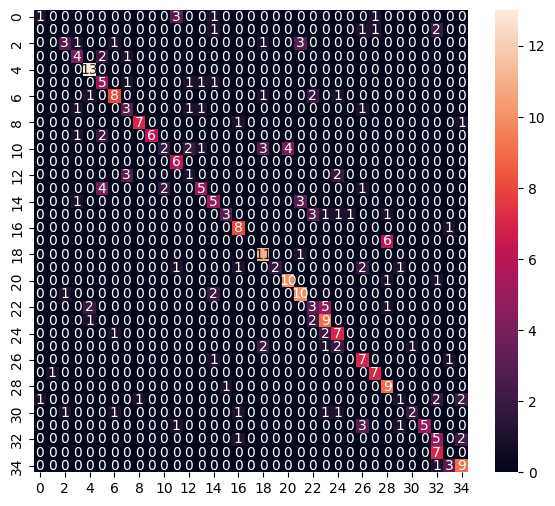

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.00      0.00      0.00         5
           2       0.60      0.33      0.43         9
           3       0.50      0.57      0.53         7
           4       0.76      1.00      0.87        13
           5       0.38      0.56      0.45         9
           6       0.73      0.62      0.67        13
           7       0.38      0.43      0.40         7
           8       0.88      0.78      0.82         9
           9       1.00      0.67      0.80         9
          10       0.50      0.17      0.25        12
          11       0.55      1.00      0.71         6
          12       0.20      0.17      0.18         6
          13       0.62      0.42      0.50        12
          14       0.45      0.56      0.50         9
          15       0.75      0.30      0.43        10
          16       0.67      0.89      0.76         9
     

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metr

In [27]:
cm, report_df = print_confusion_matrix(y_test, y_pred)

In [28]:
# calculate class accuracy
class_acc_lst = []
for i in range(len(cm)):
    class_acc = cm[i,i]/np.sum(cm,axis=1)[i]
    class_acc_lst.append(round(class_acc,2))

In [29]:
result_df = report_df.iloc[:-3, :]
result_df['accuracy'] = class_acc_lst
result_df['label'] = label_processor.get_vocabulary()

/var/folders/2s/j27_fxw134v79dglbg9qtqgc0000gn/T/ipykernel_15254/3223993405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['accuracy'] = class_acc_lst
/var/folders/2s/j27_fxw134v79dglbg9qtqgc0000gn/T/ipykernel_15254/3223993405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['label'] = label_processor.get_vocabulary()


In [30]:
result_df = result_df.sort_values(by=['accuracy'], ascending=False)
result_df

,precision,recall,f1-score,support,accuracy,label
4,0.764706,1.000000,0.866667,13.0,1.00,bitter
11,0.545455,1.000000,0.705882,6.0,1.00,colors/ color
18,0.611111,0.916667,0.733333,12.0,0.92,gum
28,0.500000,0.900000,0.642857,10.0,0.90,red
16,0.666667,0.888889,0.761905,9.0,0.89,give
27,0.777778,0.875000,0.823529,8.0,0.88,pink
20,0.714286,0.833333,0.769231,12.0,0.83,land
26,0.466667,0.777778,0.583333,9.0,0.78,perfume
8,0.875000,0.777778,0.823529,9.0,0.78,call
21,0.588235,0.769231,0.666667,13.0,0.77,learn


In [31]:
#  accuracy for the 6 models
y = [0.22, 0.47, 0.92, 0.24, 0.37, 0.55]
x = ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6']

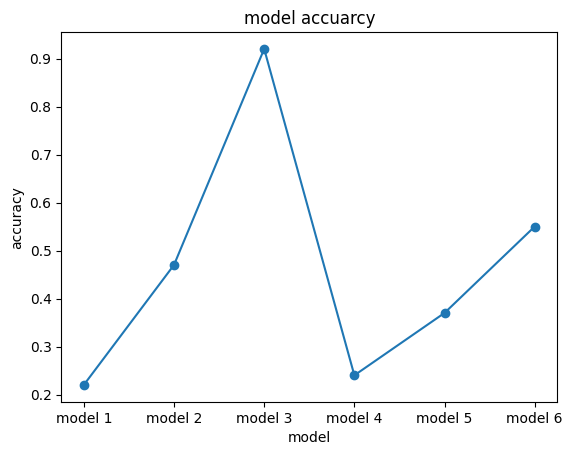

In [32]:
import matplotlib.pyplot as plt
plt.plot(x, y, '-o')
plt.xlabel('model')
plt.ylabel('accuracy')
plt.title('model accuarcy')
plt.show()